# Grayscale Image Filtering Basics
__Author__: Masa Prodanovic
__Last update__: Dec 2024

__References:__
General images: 
1) Rafael Gonzales and Richard W. Woods, Digital Image Processing, 2nd edition, Prentice Hall 2001.

2) All Python Skimage filters: https://scikit-image.org/docs/dev/api/skimage.filters.html

# Objective

We will load a few different porous media images, and introduce common gray scale image filtering techniques. 

__Filtering__ is manipulation and __always implies data/information loss__. This is done with an objective in mind, such losing noise to improve contrast between different phases in the image, or recognition of different objects.

Images differ in data types and range of values, and the first step should always be understanding histogram of the image values and basic statistics.

In [ ]:
# Import libraries

#pip install dpm_tools
#pip install scikit-image

# Anisotropic diffision filter is found in MedPy 
# https://pypi.org/project/MedPy/
#pip install medpy

try:
    import dpm_tools
    assert dpm_tools.__version__ >= "0.0.4"
except ModuleNotFoundError:
    !pip install --user --use-pep517 medpy
    !pip install --user -r ../requirements.txt
except AssertionError:
    !pip install --upgrade dpm_tools --user


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import skimage
from skimage import io, img_as_float, img_as_ubyte, img_as_int

import skimage.filters as sf
import skimage.morphology as sm
import skimage.transform as st

import dpm_tools
from dpm_tools.io import download_file
from dpm_tools.metrics import histogram_statistics as hist_stats

from medpy.filter.smoothing import anisotropic_diffusion

from skimage import exposure

from scipy import ndimage # used convolve function


# Examples
## Download and/or read in a 2D sandstone image from Digital Rocks Portal and  plot/compare image stats

I found a nice set of 2D sandstone slices at two different resolutions in Project 211. These are X-ray microtomography images.

In [1]:
#image location, this is higher resolution image (see project for more details), if it needs to be downloaded
#file_url1 = "https://www.digitalrocksportal.org/projects/211/images/126114/download/";
filename1 = "../data/Project211_sandstone_slice_0801hr.png"
# download_file(file_url1, filename1) #uncomment if you need to download again

# image location, this is a lower resolution image (see project)
#file_url2 = "https://www.digitalrocksportal.org/projects/211/images/126113/download/"
filename2 = "../data/Project211_sandstone_slice_0801lr.png"
# download_file(file_url1, filename1) #uncomment if you need to download again


__These images are the same sample imaged at higher and lower resolutions.__
__We read images, and display the entire images as well as smaller subsets where we can appreciate the differences.__

__Color shown is the default colormap of matplotlib. This is NOT true color, x-ray images have single values, but I use it instead of
gray as differences on screen tend to be better visible than in gray__

Text(0.5, 1.0, 'zoom in - lower res')

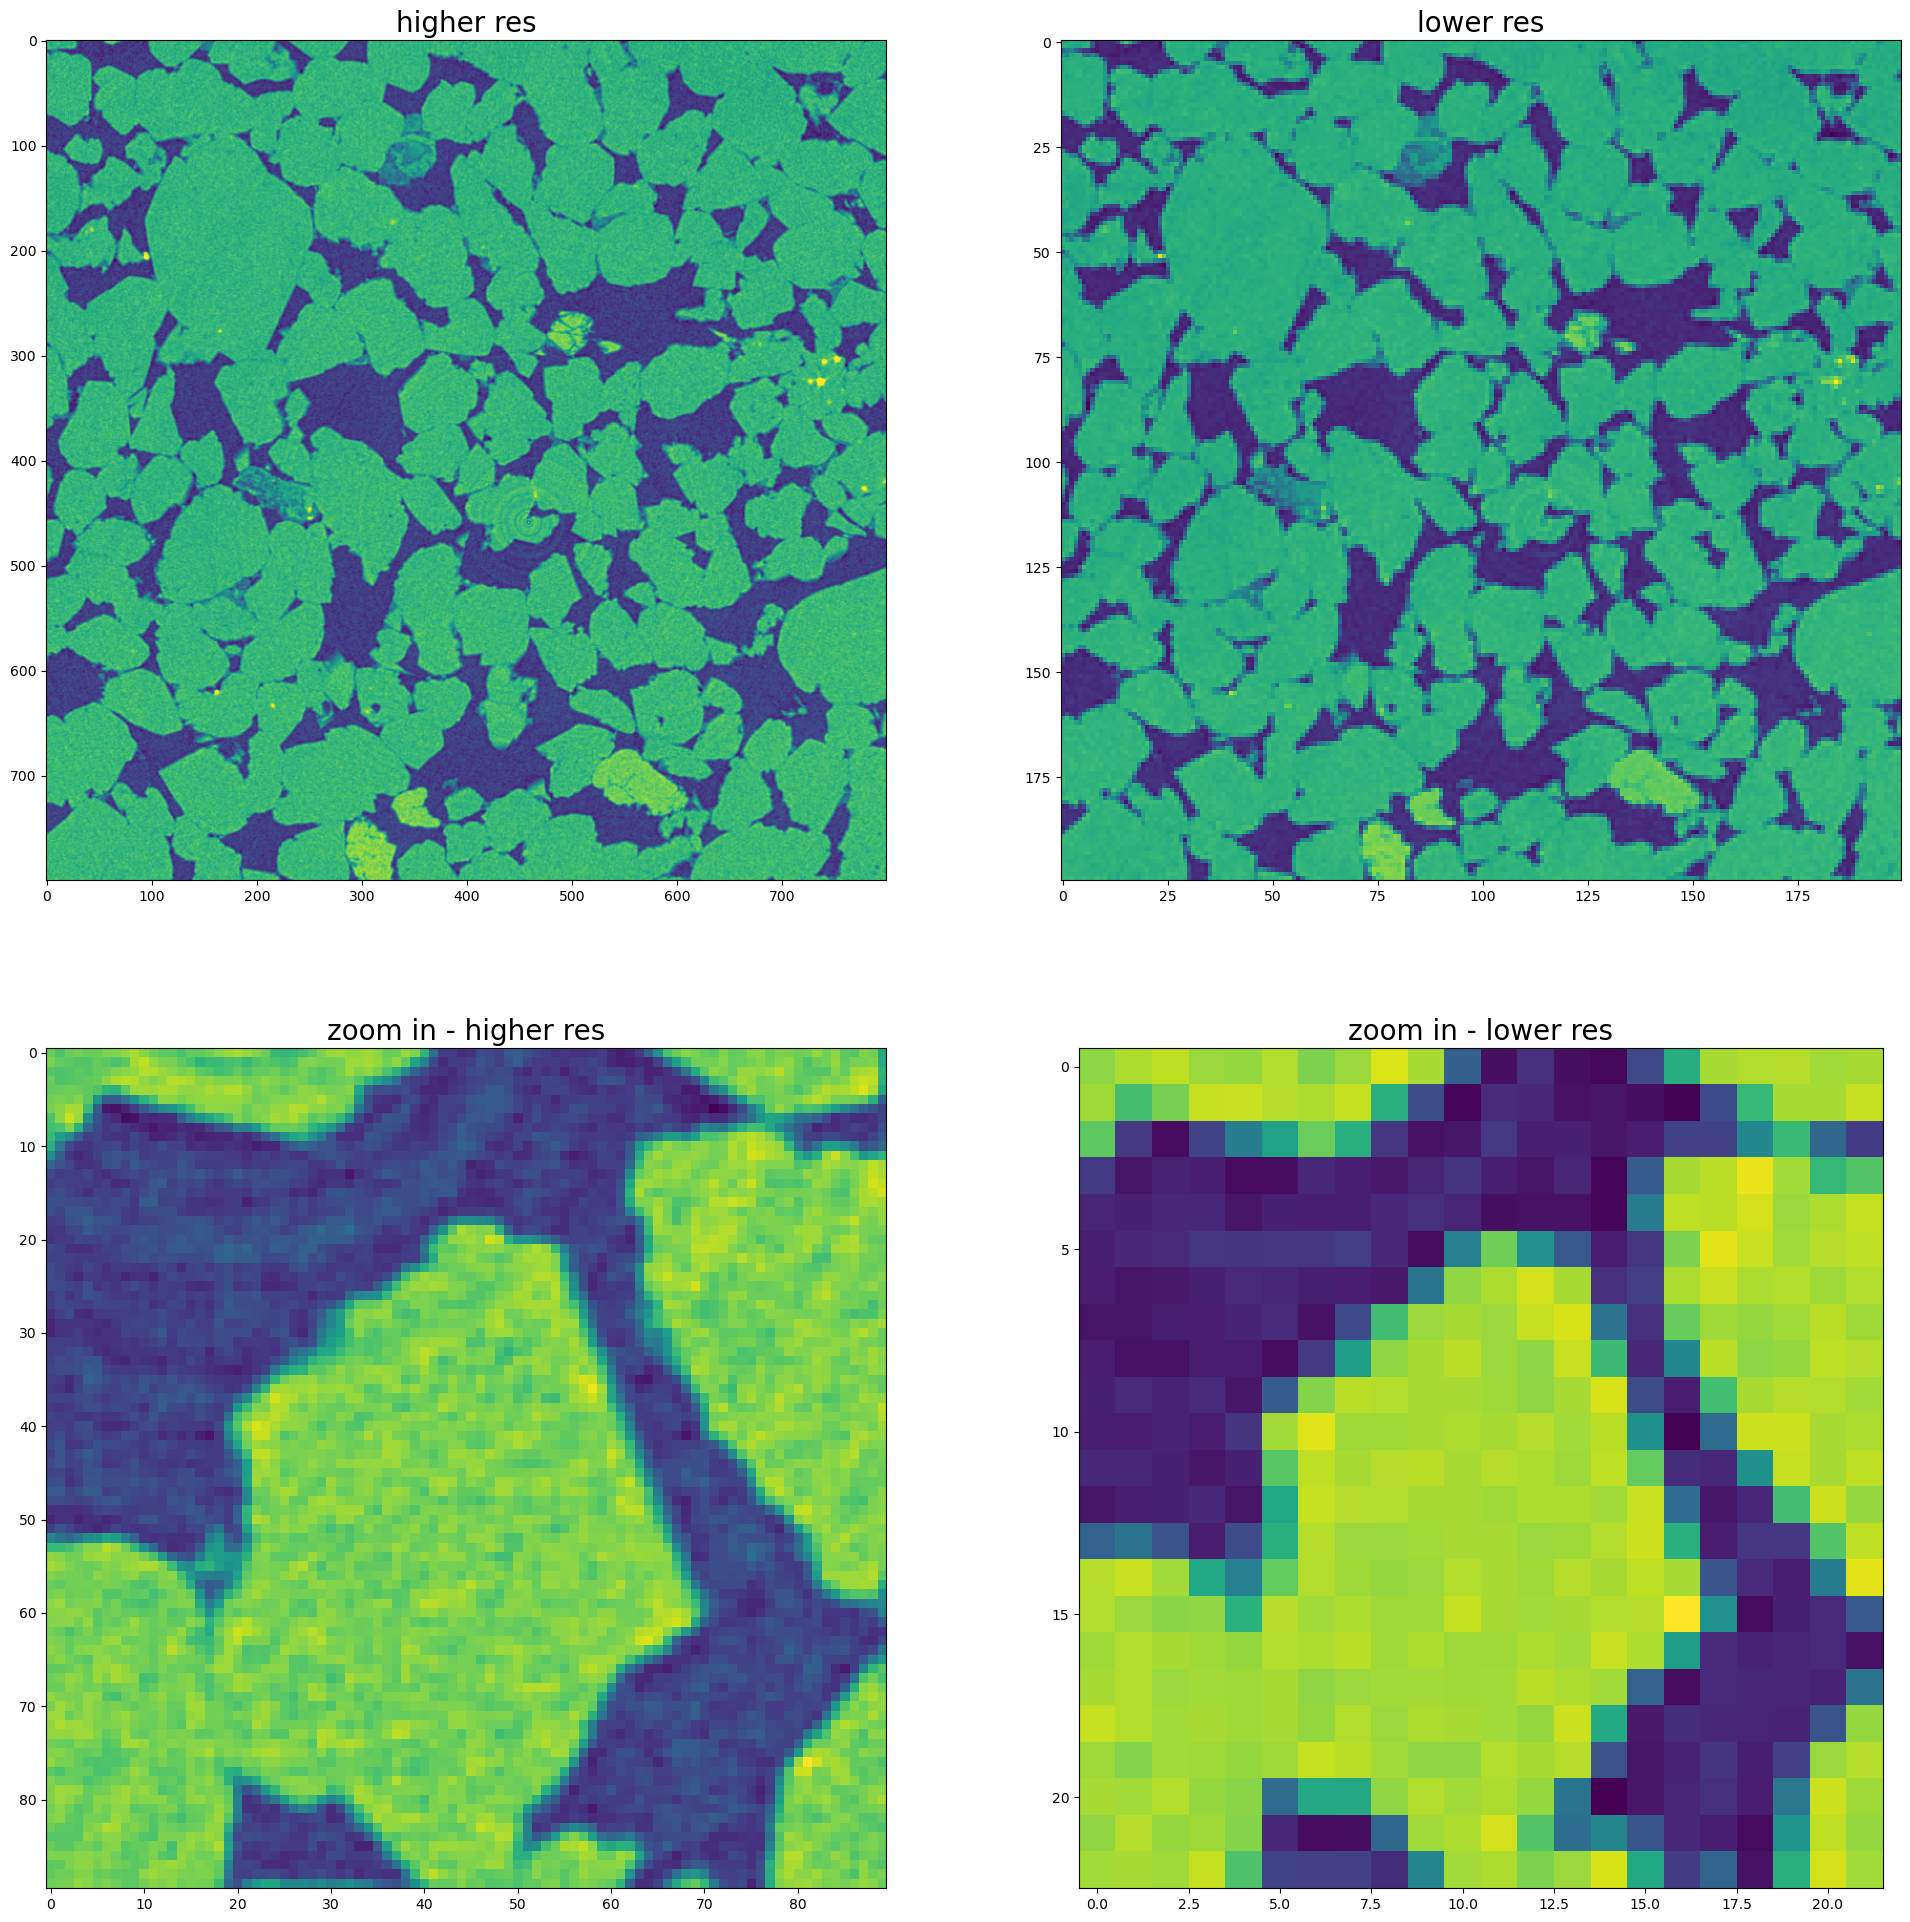

In [4]:
img_hr = io.imread(filename1) # read the file
img_hr = img_hr[:,:,0] #use only one channel of the three channels available

img_lr = io.imread(filename2) # read the file
img_lr = img_lr[:,:,0] #use only one channel of the three channels available

f = plt.figure(figsize=(24, 24))
f.add_subplot(221)
plt.imshow(img_hr) # if the image has three channels, default - and fake - color will appear when using imshow. Color scheme can easily be changed.
plt.title('higher res',fontsize=20)

f.add_subplot(222)
plt.imshow(img_lr) # if the image has three channels, default - and fake - color will appear when using imshow
plt.title('lower res',fontsize=20)

# location and length of an image subset in x, y directions
locx = 470
lenx = 90
locy = 440
leny = 90

f.add_subplot(223)
plt.imshow(img_hr[locx:(locx+lenx),locy:(locy+leny)]) # add cmap='gray' to imshow function to change colormap to gray.
plt.title('zoom in - higher res',fontsize=20)

f.add_subplot(224)
# note that // is floor division (so we get integers as a result)
plt.imshow(img_lr[locx//4:(locx+lenx)//4,locy//4:(locy+leny)//4]) 
plt.title('zoom in - lower res',fontsize=20)


__Now look into the basic statistics of the images. Do you think we will observe a difference in the image histograms and what will the difference be?__

-----------------------------------
Image statistics:
	Shape: (800, 800)
	Data type: uint8
	Min: 20, Max:               255, Mean: 148.16875625

-----------------------------------
Image statistics:
	Shape: (200, 200)
	Data type: uint8
	Min: 35, Max:               255, Mean: 148.17455



[{'shape': (800, 800),
  'dtype': dtype('uint8'),
  'min': 20,
  'max': 255,
  'mean': 148.16875625,
  'median': 172.0,
  'variance': 2288.5133432030857,
  'skewness': 0.0,
  'kurtosis': -1.200036621652552},
 {'shape': (200, 200),
  'dtype': dtype('uint8'),
  'min': 35,
  'max': 255,
  'mean': 148.17455,
  'median': 173.0,
  'variance': 2078.3071822975,
  'skewness': 0.0,
  'kurtosis': -1.2000366216525522}]

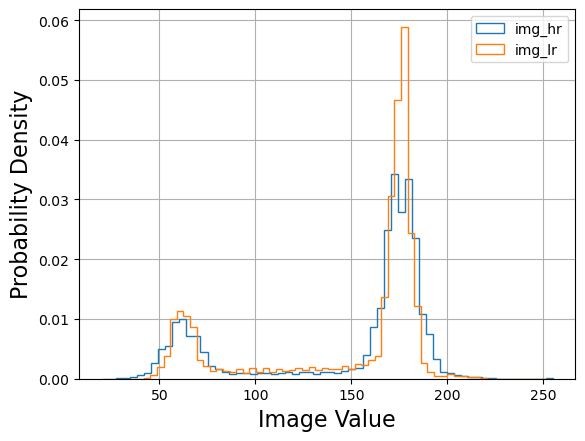

In [21]:
# I would typically use 256 bins here, however, it seems that some of the values in 0..255 
# range do not exist in the images, so that creates an ugly histogram.
hist_stats(img_hr, img_lr, plot_histogram=True, nbins=64, legend_elem=["img_hr", "img_lr"])

## Geometric transformations
Rotation is something that you would commonly do for engineering reasons, 
and it is not filtering per se. This is one example using skimage library. Check skimage.transform for more.

Note that by conventions, skimage functions convert all images to [0,1] float64 range. That is necessary for operations that often have non-integer result. This may cause error in calculation as well as increase the memory footprint of your calculation.

Using skimage.transform.rotate() function:
https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate

-----------------------------------
Image statistics:
	Shape: (50, 50)
	Data type: float64
	Min: 0.13725490196078433, Max:               0.803921568627451, Mean: 0.5936203921568628

-----------------------------------
Image statistics:
	Shape: (50, 50)
	Data type: float64
	Min: 0.0, Max:               0.7755461284234941, Mean: 0.49022097883913923

-----------------------------------
Image statistics:
	Shape: (50, 50)
	Data type: float64
	Min: 7.178572240973402e-06, Max:               0.7686274509803921, Mean: 0.11173145711638933



Text(0.5, 1.0, 'Difference')

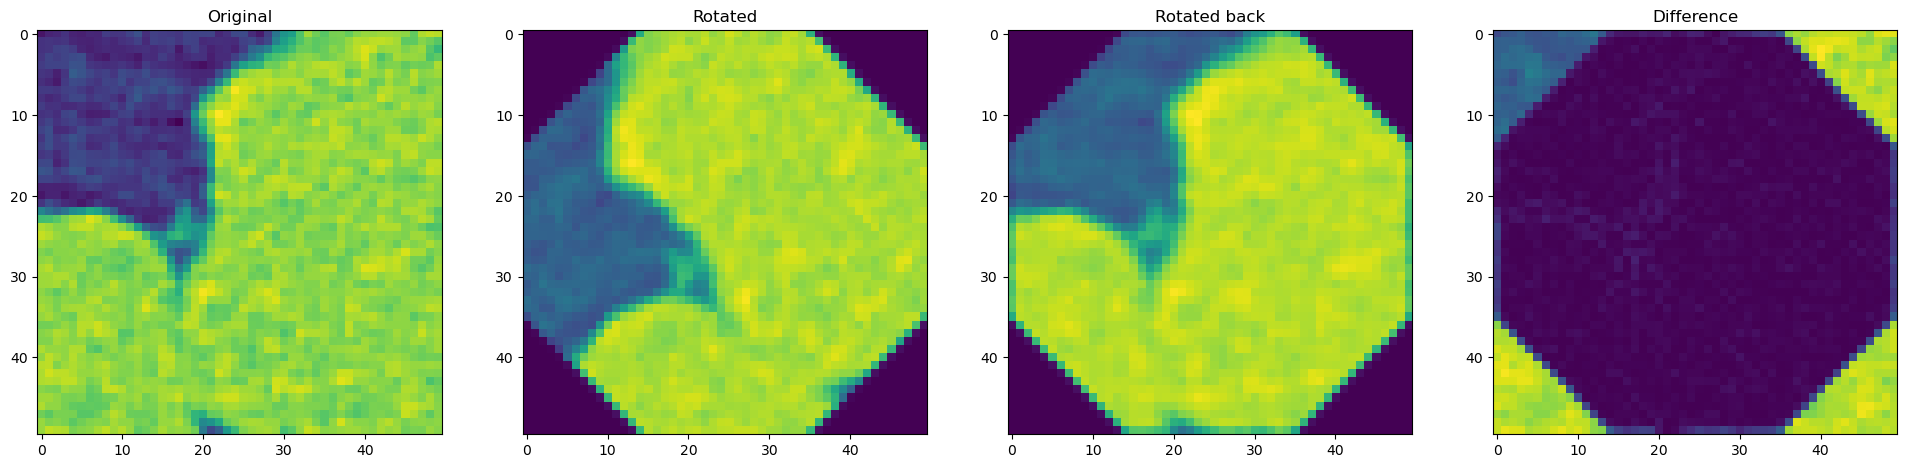

In [7]:

# location and length of an image subset in x, y directions
locx = 500
lenx = 50
locy = 440
leny = 50

f.add_subplot(223)
img_sub = img_as_float(np.copy(img_hr[locx:(locx+lenx),locy:(locy+leny)]))
angle = 45; # counter-clockwise angle of rotation
img_rot = st.rotate(img_sub,angle)
img_back = st.rotate(img_rot,-angle)
#img_diff = np.ubyte(np.round(img_sub - img_back))
img_diff = np.abs(img_sub-img_back)

hist_stats(img_sub)
hist_stats(img_back)
hist_stats(img_diff)

f = plt.figure(figsize=(24, 24))
f.add_subplot(141)
plt.imshow(img_sub)
plt.title('Original')

f.add_subplot(142)
plt.imshow(img_rot)
plt.title('Rotated')

f.add_subplot(143)
plt.imshow(img_back)
plt.title('Rotated back')

f.add_subplot(144)
plt.imshow(img_diff)
plt.title('Difference')



## Gaussian smoothing

The simplest filter and very common filter that removes "speckled" noise, but it also smooths out (and possibly even removes) edges or thin features: __in porous media use very very cautiously (if at all!), especially if contrast is not good.__


[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]
Mild smoothing, sigma = 0.4
 [[0.00163116 0.03712502 0.00163116]
 [0.03712502 0.84496158 0.03712502]
 [0.00163116 0.03712502 0.00163116]]
More smoothing, sigma = 1
 [[0.05855018 0.09653293 0.05855018]
 [0.09653293 0.15915589 0.09653293]
 [0.05855018 0.09653293 0.05855018]]
Reflected boundaries, sigma = 1
 [[0.08767308 0.12075024 0.08767308]
 [0.12075024 0.16630671 0.12075024]
 [0.08767308 0.12075024 0.08767308]]


Text(0.5, 1.0, 'Gaussian, sigma = 1, reflect boundaries')

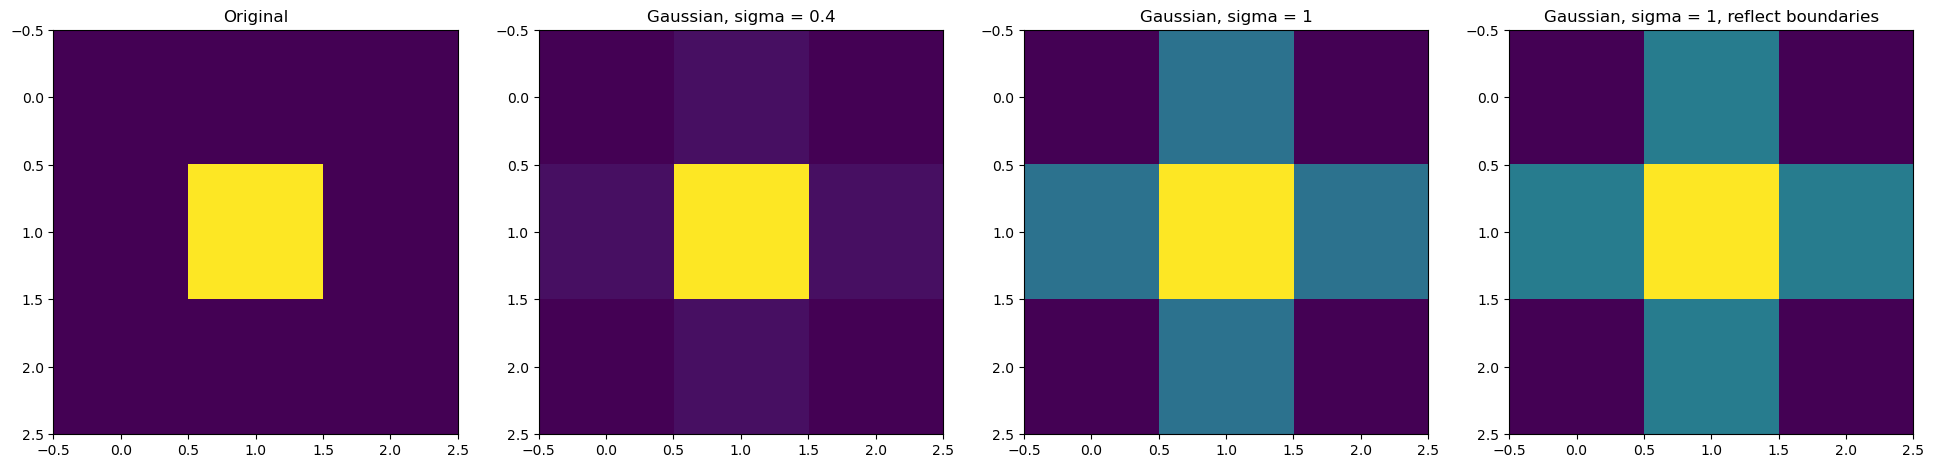

In [8]:
import skimage as si
import skimage.filters as sf

# Create a simple, 3 by 3 image with only one point feature which is one voxel. 
a = np.zeros((3, 3))
a[1, 1] = 1
print(a)
a_smooth = sf.gaussian(a, sigma=0.4)
print('Mild smoothing, sigma = 0.4\n', a_smooth)

a_smoother = sf.gaussian(a, sigma=1) 
print('More smoothing, sigma = 1\n', a_smoother)

# Several modes are possible for handling boundaries
a_reflect = sf.gaussian(a, sigma=1, mode='reflect')
print('Reflected boundaries, sigma = 1\n', a_reflect)

f = plt.figure(figsize=(24, 24))

f.add_subplot(141)

plt.imshow(a)
plt.title('Original')

f.add_subplot(142)
plt.imshow(a_smooth)
plt.title('Gaussian, sigma = 0.4')

f.add_subplot(143)
plt.imshow(a_smoother)
plt.title('Gaussian, sigma = 1')

f.add_subplot(144)
plt.imshow(a_reflect)
plt.title('Gaussian, sigma = 1, reflect boundaries')

#>>> # For RGB images, each is filtered separately
#>>> from skimage.data import astronaut
#>>> image = astronaut()
#>>> filtered_img = gaussian(image, sigma=1, multichannel=True)

__Exercise__: create a 5 x 5 image with a straight line feature through its middle. Then apply the above three filters to observe what happens during smoothing.

__Let's now "smooth" one of the sandstone images above, and plot differences__

On the difference plot, most values are very small but notably the largest changes (absolute differences) are near the boundary of two phases. __That reduces contrast between two materials, and is very bad effect.__

We will also report PSNR and MSE measures between the image and its filtered version.


Gaussian, sigma=1.0, psnr= 4.173289397527172    mse= 24874.33168589642


C:\Users\masha\AppData\Local\Temp\ipykernel_10360\2459571073.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(img_sub, img_smoother)


Text(0.5, 1.0, 'Abs. difference (for sigma=1)')

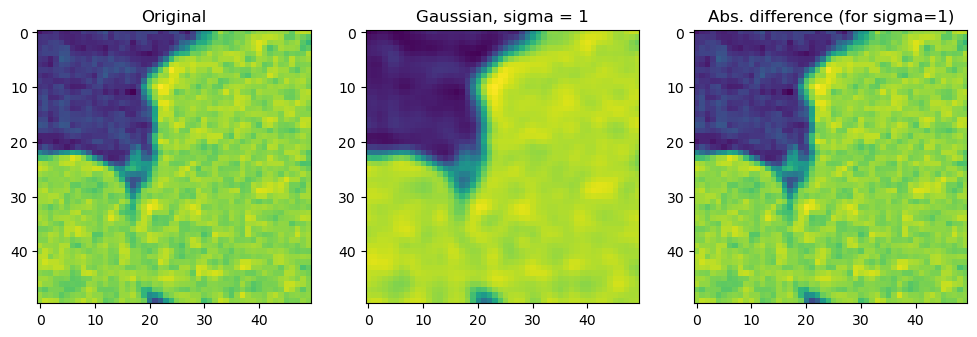

In [66]:
from skimage.metrics import peak_signal_noise_ratio, mean_squared_error

f = plt.figure(figsize=(12, 18))

f.add_subplot(131)

plt.imshow(img_sub)
plt.title('Original')

img_smoother = sf.gaussian(img_sub,1)
f.add_subplot(132)
plt.imshow(img_smoother)
plt.title('Gaussian, sigma = 1')

psnr = peak_signal_noise_ratio(img_sub, img_smoother)
mse = mean_squared_error(img_sub,img_smoother)
print('Gaussian, sigma=1.0, psnr=',psnr, '   mse=',mse)

f.add_subplot(133)
img_diff = np.abs(img_smoother-img_sub)
plt.imshow(img_diff)
plt.title('Abs. difference (for sigma=1)')


-----------------------------------
Image statistics:
	Shape: (50, 50)
	Data type: float64
	Min: 1.7290586780682737e-05, Max:               0.1276976890073689, Mean: 0.01877713833264988



[{'shape': (50, 50),
  'dtype': dtype('float64'),
  'min': 1.7290586780682737e-05,
  'max': 0.1276976890073689,
  'mean': 0.01877713833264988,
  'median': 0.014660801653013589,
  'variance': 0.0002923145203150992,
  'skewness': -2.706633220467733e-16,
  'kurtosis': -1.200036621652552}]

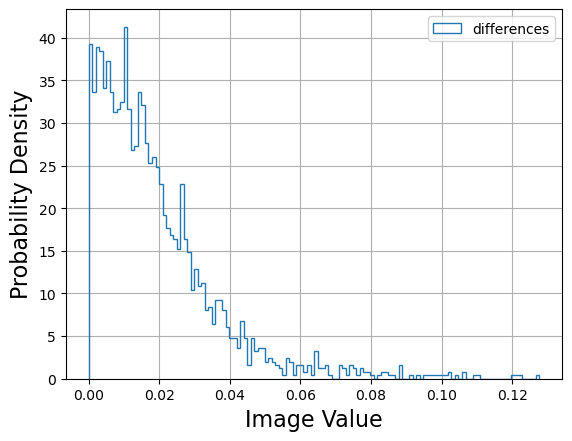

In [13]:
# If the image is dominated by small values, we might have hard times seeing a few of them that are larger.
hist_stats(img_diff,plot_histogram=True,nbins=128,legend_elem=['differences'])

-----------------------------------
Image statistics:
	Shape: (800, 800)
	Data type: float64
	Min: 0.0784313725490196, Max:               1.0, Mean: 0.5810539460784314

-----------------------------------
Image statistics:
	Shape: (800, 800)
	Data type: float64
	Min: 0.13687703313565477, Max:               0.9998484846768962, Mean: 0.581054107534407



[{'shape': (800, 800),
  'dtype': dtype('float64'),
  'min': 0.0784313725490196,
  'max': 1.0,
  'mean': 0.5810539460784314,
  'median': 0.6745098039215687,
  'variance': 0.035194361294934036,
  'skewness': -5.528155746483105e-16,
  'kurtosis': -1.2000366216525513},
 {'shape': (800, 800),
  'dtype': dtype('float64'),
  'min': 0.13687703313565477,
  'max': 0.9998484846768962,
  'mean': 0.581054107534407,
  'median': 0.6764128778554637,
  'variance': 0.03198742037540669,
  'skewness': -1.122077305771406e-16,
  'kurtosis': -1.200036621652552}]

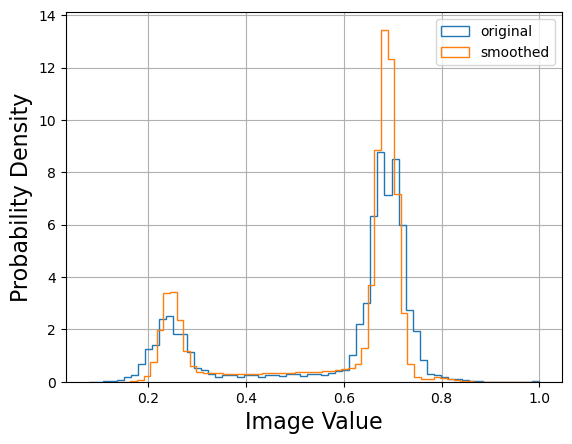

In [20]:
# Use Gaussian smoothing on the entire image and visualize impact on histogram.
img_hr_float = si.img_as_float(img_hr)
img_hr_smooth = sf.gaussian(img_hr_float,1.0)
hist_stats(img_hr_float,img_hr_smooth,plot_histogram=True,nbins=64,legend_elem=["original", "smoothed"])


## Median filtering

We can replace a voxel with the median of the values in its __neighborhood__ or so-called __structuring element__.  For this we first need to define what the neighborhood is, and depending on its size, the effect of filtering is smaller or bigger. We will stick to squares/cubes or disks/balls
but the neighborhoods could be anything. You can read more here: https://scikit-image.org/docs/dev/auto_examples/numpy_operations/plot_structuring_elements.html#sphx-glr-auto-examples-numpy-operations-plot-structuring-elements-py

__Median filter__ is likely one of the best filters to use in porous media images, especially CT images. It sorts the values in a given neighborhood, and finds the median. If I have a 3 by 3 neighborhood, and some noise that is less than 3*3/2 in area, than that noise will be replaced. Statistically speaking, the median is 50th percentile of a ranked set of numbers. I could also choose maximum (100th percentile), minimum (0th percentile) and anything in between.

CT noise is complex (not randomized, but nonlinear), and median filtering with a relatively small
neighbohood of 3 to 5 voxels wide will remove noise that occupies smaller areas, and will not have a large effect on the boundaries (edges) between phases that Gaussian filter might blur.



Further, by design it does _not_ introduce new values (i.e. numbers that previously did not exist) into the image. This is good since I could operate on integers, and the resulting image is still integer.

__Structural elements: examples__

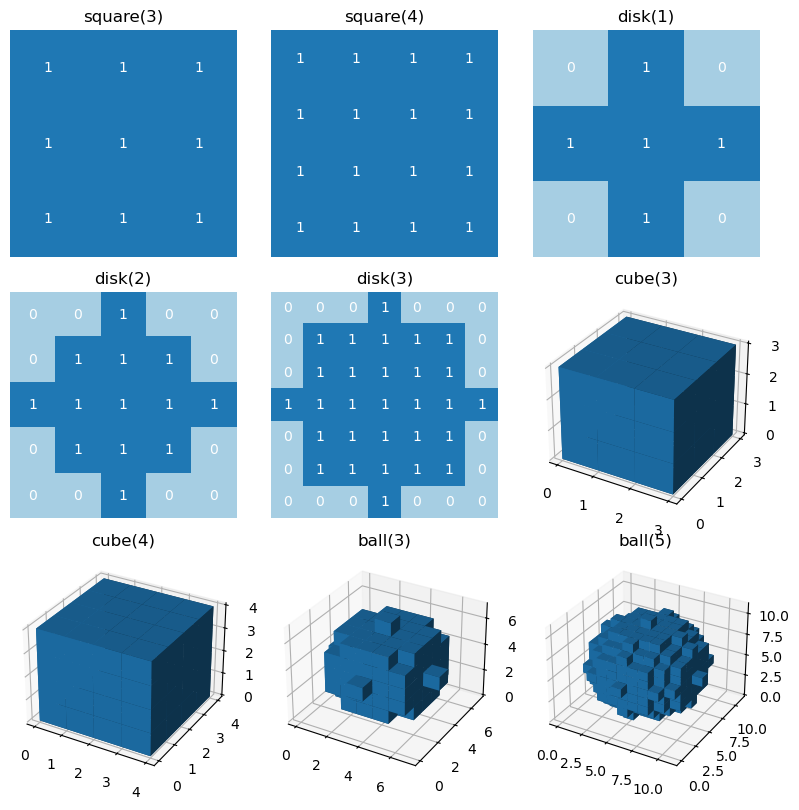

In [23]:
# let's create different neighborhooods in different shapes
# Example is from skimage documentation.

struc_2d = {
    "square(3)": sm.square(3),
    "square(4)": sm.square(4),
    "disk(1)": sm.disk(1),
    "disk(2)": sm.disk(2),
    "disk(3)": sm.disk(3)
}

struc_3d = {
    "cube(3)": sm.cube(3),
    "cube(4)": sm.cube(4),
    "ball(3)": sm.ball(3),
    "ball(5)": sm.ball(5)
}

# Visualize the elements.
fig = plt.figure(figsize=(8, 8))

idx = 1
for title, struc in struc_2d.items():
    ax = fig.add_subplot(3, 3, idx)
    ax.imshow(struc, cmap="Paired", vmin=0, vmax=12)
    for i in range(struc.shape[0]):
        for j in range(struc.shape[1]):
            ax.text(j, i, struc[i, j], ha="center", va="center", color="w")
    ax.set_axis_off()
    ax.set_title(title)
    idx += 1

for title, struc in struc_3d.items():
    ax = fig.add_subplot(3, 3, idx, projection=Axes3D.name)
    ax.voxels(struc)
    ax.set_title(title)
    idx += 1

fig.tight_layout()
plt.show()



Text(0.5, 1.0, 'Abs. difference')

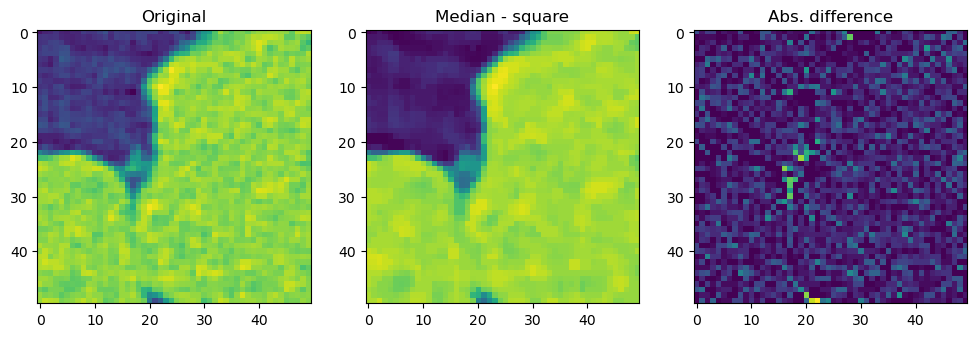

In [65]:
f = plt.figure(figsize=(12, 18))

f.add_subplot(131)

img_sub = np.copy(img_hr[locx:(locx+lenx),locy:(locy+leny)])

plt.imshow(img_sub)
plt.title('Original')

f.add_subplot(132)
img_med = sf.median(img_sub,sm.square(3))
plt.imshow(img_med)
plt.title('Median - square')

f.add_subplot(133)
img_diff = np.abs(img_as_int(img_med)-img_as_int(img_sub)) # convert to int for math to work if negative numbers show up.
plt.imshow(img_diff)
plt.title('Abs. difference')

# hist_stats(img_diff,plot_histogram=True,nbins=32,legend_elem=['Abs. differences'])

## Mean filtering (averaging)
We could also replace every pixel with the mean (average) of the values in the defined neighborhood. It should be relatively obvious how this would "smooth" out any extreme differences in the image.
https://scikit-image.org/docs/dev/api/skimage.filters.rank.html#skimage.filters.rank.mean

__If you compare the difference image to the median filter difference image above, you will see that 
median filter does not smooth the boundary of the material as much. That is good for contrast.__


Text(0.5, 1.0, 'Abs. difference')

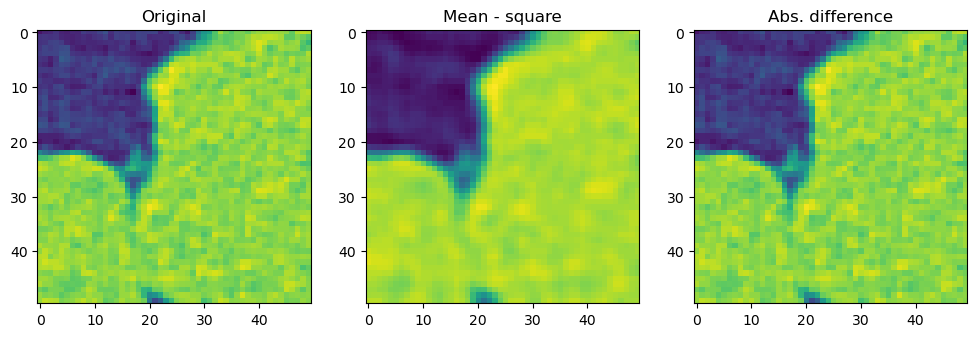

In [64]:
f = plt.figure(figsize=(12, 18))

f.add_subplot(131)

plt.imshow(img_sub)
plt.title('Original')

f.add_subplot(132)
img_mean = sf.rank.mean(img_sub,sm.square(3))
plt.imshow(img_mean)
plt.title('Mean - square')

f.add_subplot(133)
img_diff = np.abs(si.img_as_float(img_mean)-img_sub)
plt.imshow(img_diff)
plt.title('Abs. difference')


## Anisotropic diffusion

We will use a carbonate example with microporosity where the filtering really matters.

### Carbonate example with microporosity: read image (2D) from Digital Rocks Portal

This example has pore space, microporous space and solid phase. Microporosity is not well resolved, and in return the histogram does not show clear three peaks as the phases are not well separated.

I am showing it in gray scale this time around, change it if you'd like.


[22:53:28] WARNING  <tifffile.TiffPage 0 @8000068> <tifffile.TiffTag 320 @8000226> invalid value  ]8;id=345304;file://C:\Users\masha\anaconda3\Lib\site-packages\tifffile\tifffile.py\tifffile.py]8;;\:]8;id=30747;file://C:\Users\masha\anaconda3\Lib\site-packages\tifffile\tifffile.py#23448\23448]8;;\
                    offset 0                                                                                       

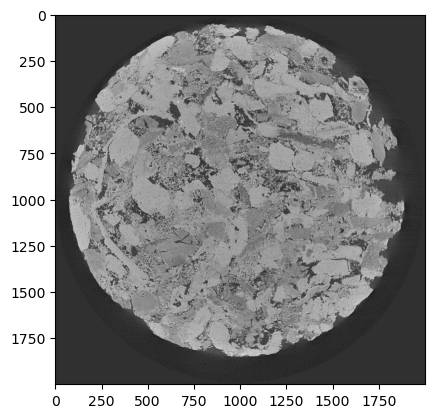

In [69]:

#download
# Project 58, Estaillades carbonate #2 has a nice if complex CT of a carbonate sample
file_url3 = "https://www.digitalrocksportal.org/projects/58/images/68987/download/"

# Option 1: img_carbonate = io.imread(file_url) # this is how to read directly from online source

filename3  = "../data/ES32_0135.tif"
# Download
# download_file(file_url3,filename3)
# Read from downloaded file
img_carbonate = io.imread(filename3)

#filename2 = "ES32_0135.tif"
#img_carbonate = io.imread(filename2)

plt.imshow(img_carbonate,cmap='gray')
#plt.imshow(img_carbonate)
#hist_stats(img_carbonate,plot_histogram=True,nbins=128,legend_elem=['original'])

The ultimate goal is to see three peaks (or the emergence of the three peaks) in the histogram of the carbonate example without smoothing across the boundaries between region pairs. There is too much overlap between phase peaks, and I would not trust image thresholding in this type of a material.

We will try anisotropic diffusion from medPy
http://loli.github.io/medpy/generated/medpy.filter.smoothing.anisotropic_diffusion.html


(2000, 2000)
-----------------------------------
Image statistics:
	Shape: (300, 300)
	Data type: uint16
	Min: 5693, Max:               63714, Mean: 34106.38991111111

-----------------------------------
Image statistics:
	Shape: (300, 300)
	Data type: float32
	Min: 7474.10107421875, Max:               62731.19921875, Mean: 34106.38671875



[{'shape': (300, 300),
  'dtype': dtype('uint16'),
  'min': 5693,
  'max': 63714,
  'mean': 34106.38991111111,
  'median': 36859.0,
  'variance': 80087465.64254712,
  'skewness': 1.0391930368871406e-16,
  'kurtosis': -1.2000366216525522},
 {'shape': (300, 300),
  'dtype': dtype('float32'),
  'min': 7474.101,
  'max': 62731.2,
  'mean': 34106.387,
  'median': 36895.758,
  'variance': 77400104.0,
  'skewness': 3.8753308954455813e-07,
  'kurtosis': -1.2000364100939922}]

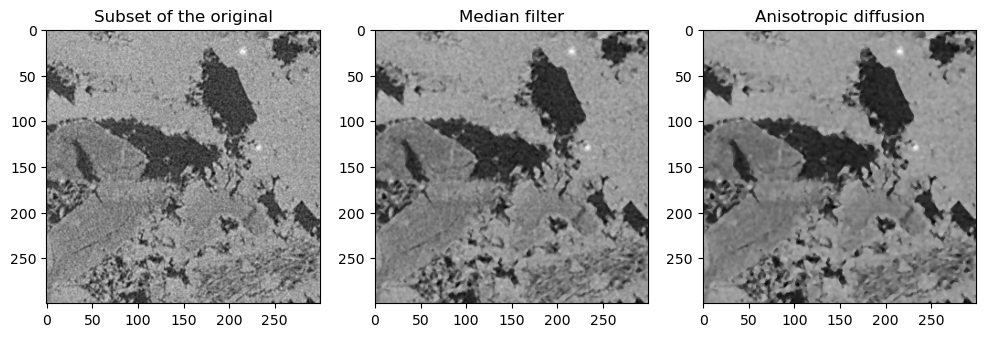

<Figure size 640x480 with 0 Axes>

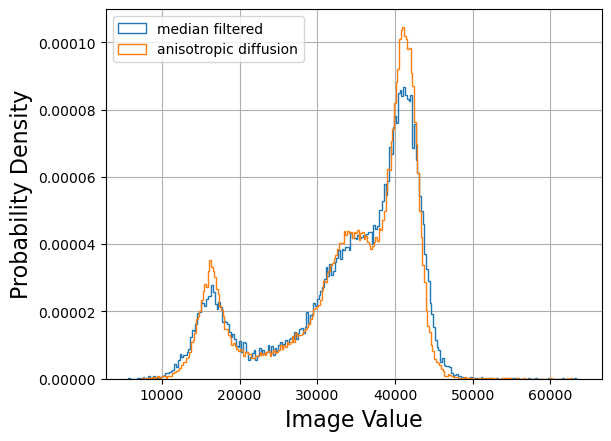

In [70]:
# This is a large slice...take a subsample 
print(img_carbonate.shape)

#Subsample
N=300
img_csub = img_carbonate[450:450+N,450:450+N]

f = plt.figure(figsize=(12,18))

f.add_subplot(131)
plt.imshow(img_csub,cmap='gray')
plt.title("Subset of the original")

f.add_subplot(132)
img_cmed = sf.median(img_csub,sm.square(3))
plt.imshow(img_cmed,cmap='gray')
plt.title('Median filter')

f.add_subplot(133)
# I have to use pretty large kappa as image values here are large (otherwise nothing happens)
# See histogram for comparison of before and after anisotropic diffusion. 
# I need three "peaks" to start forming, as there is pore space, solid phase and microporous phase.

# Also note: the algorithm below does NOT convert images to [-1,1] floats the way skimage does.
# It simply converts them to a floating point, equivalent value.
img_ani = anisotropic_diffusion(img_cmed,kappa=5000,niter=5,gamma=0.2,option=3)
plt.imshow(img_ani,cmap='gray')
plt.title('Anisotropic diffusion')

# image histogram is now stored in a separate Python file drp_util.py
plt.figure()
hist_stats(img_cmed,img_ani,plot_histogram=True,nbins=256,legend_elem=['median filtered','anisotropic diffusion'])

## Beyond basics: Spatial filtering and convolutions

With simple examples above we have intuitively introduced ideas of spatial filtering basics, that are intimately linked to the idea of convolutions and cross-correlations....this requires a bit of handwritten notes.

Reading: section 3.5 in R. Gonzales and R. W. Woods, Digital Image Processing, 2nd edition, Prentice Hall 2001.  (digital access possible through UT Library)

Videos:
Convolutions and cross-correlation by G. Jensen (Caltech, 15min):
https://www.youtube.com/watch?v=MQm6ZP1F6ms

The above video is the last part of the series on Fourier Transforms in imaging applications: https://www.youtube.com/watch?v=-EAQm8wgLbc

Visual intro to Fourier Transform (3blue1brown, 20min): https://www.youtube.com/watch?v=spUNpyF58BY

__Issues to resolve above:__
- Why is probability in histograms above > 1 in some cases?
- sf.rank.mean returns uint8 image. Why is that?



### Convolution with user-defined kernel

The function scipy.ndimage.convolve can convolve any ndarray with a predefined kernel.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html#scipy.ndimage.convolve
    
We will use it to show Laplacian (second order differential operator) of an image. Both input and output are rather noisy.

Text(0.5, 1.0, 'Laplace isotropic')

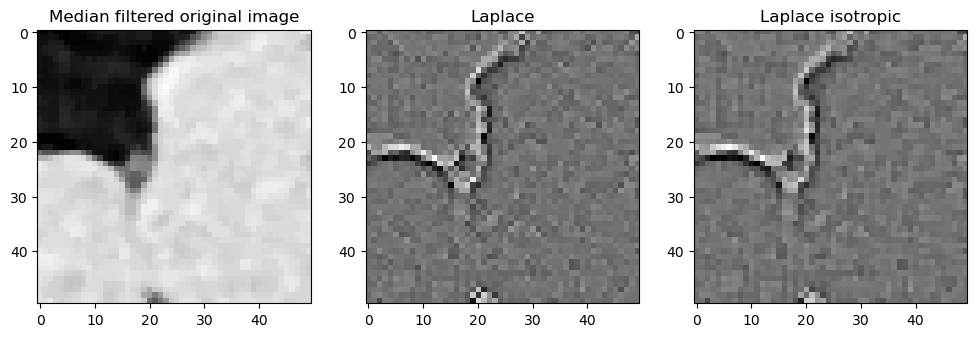

In [77]:
# We derived Laplacian kernel in class. 
k_l = np.array([[0,1,0],  [1,-4,1],  [0,1,0]])

#Isotropic version of the Laplacian kernel has diagonal elements as well
k_l_iso = np.array([[1,1,1], [1,-8,1], [1,1,1]])



img_laplace= ndimage.convolve(img_as_float(img_med), k_l, mode='reflect')
img_laplace_iso= ndimage.convolve(img_as_float(img_med), k_l_iso, mode='reflect')

f = plt.figure(figsize=(12, 18))

f.add_subplot(131)

plt.imshow(img_med,cmap='gray')
plt.title('Median filtered original image')

f.add_subplot(132)
plt.imshow(img_laplace,cmap='gray')
plt.title('Laplace')

f.add_subplot(133)
plt.imshow(img_laplace_iso,cmap='gray')
plt.title('Laplace isotropic')



Image (ndarray) shape (50, 50)

Image data type float64

Image values min: -0.6039215686274508 max: 0.4784313725490198 mean: -7.860379014346108e-17


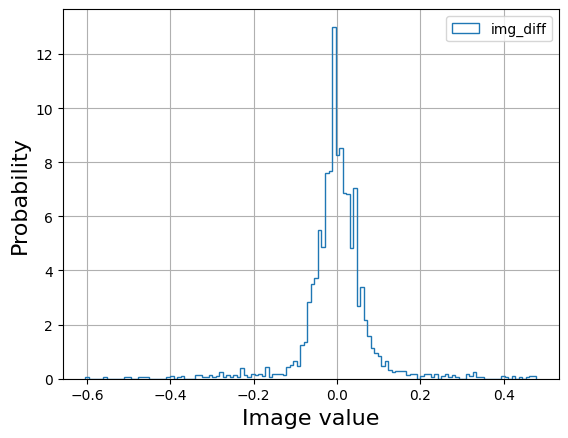

Text(0.5, 1.0, 'Laplace isotropic and Laplace difference')

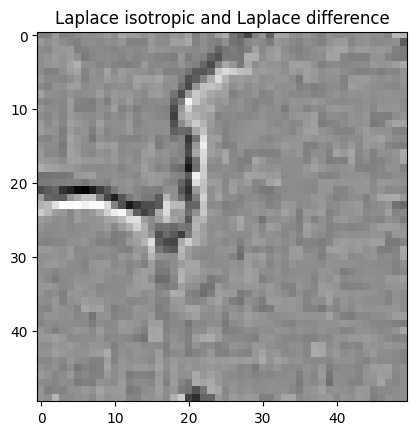

In [32]:
img_diff = img_laplace - img_laplace_iso
image_statistics_multi(img_diff,plot_histogram=True,nbins=128)
plt.imshow(img_diff,cmap='gray')
plt.title('Laplace isotropic and Laplace difference')

### Gradient (magnitude) and edge finding
__Sobel__ filter is a variant that computes computational-time-friendly version of 
the gradient magnitude. 

$$ \sqrt(\frac{\partial f}{\partial x}^2 + \frac{\partial f}{\partial y }^2)$$

It is used to identify edges in an image.

Text(0.5, 1.0, 'Sobel')

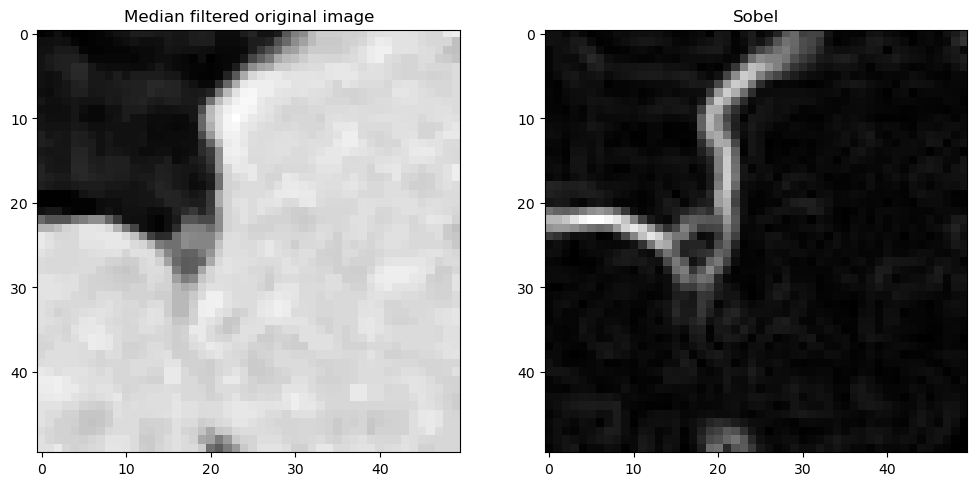

In [72]:
f = plt.figure(figsize=(12, 12))

f.add_subplot(121)

plt.imshow(img_med,cmap='gray')
plt.title('Median filtered original image')

f.add_subplot(122)
img_sobel = sf.sobel(img_med)
plt.imshow(img_sobel,cmap='gray')
plt.title('Sobel')



### SEPARATE FROM THIS LECTURE Correlation as a way to register images or match templates

We first try a very basic correlation. It does not work well - see below.



Image (ndarray) shape (800, 800)

Image data type float64

Image values min: 571.3738869665522 max: 2912.719292579771 mean: 2295.5087067570416


()

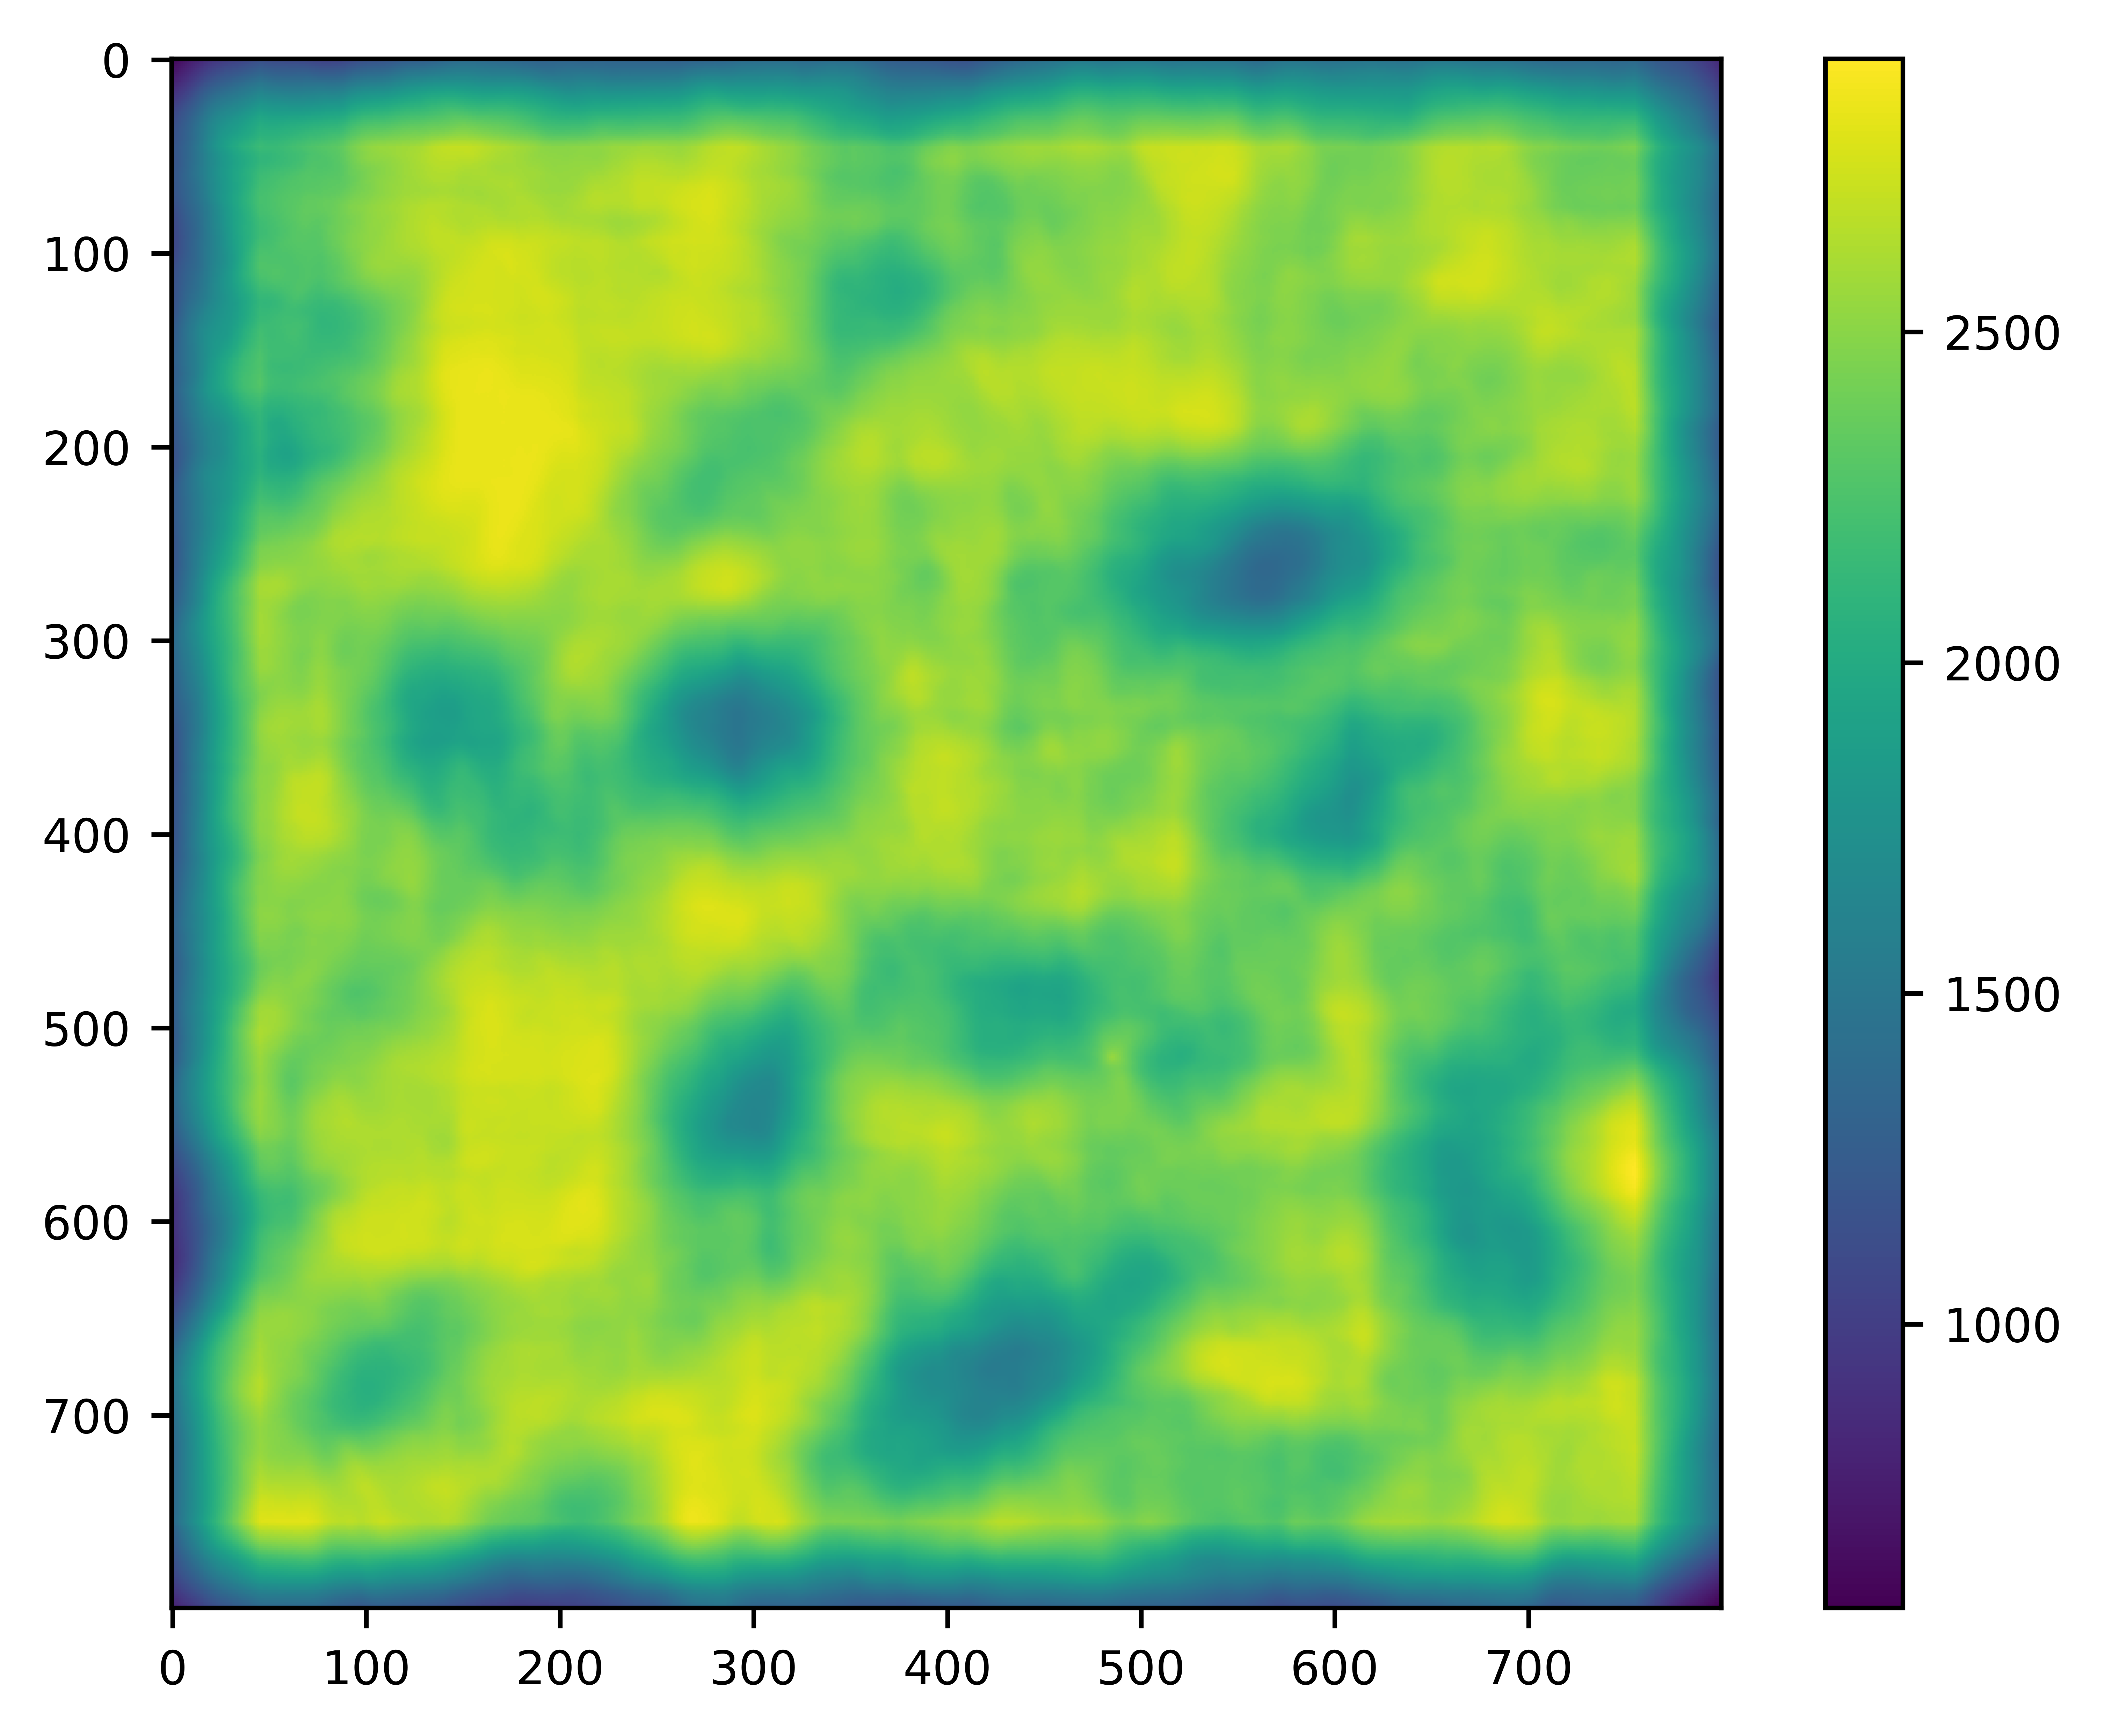

In [73]:
# This is a simple correlation, to see if it works.
# I expect the sub image when overlapped its original version to have a high number
# resulting from correlating/convolving it.
#
# It fails to find the match pretty misearably, I am thinking because:
# - correlation is done using the original and fairly noisy image with a wide range 
#   of values
# - the small pore structure in subset is likely found in multiple locations in the image

import skimage as si
from scipy import ndimage

#Recreate subset of an image
# location and length of an image subset in x, y directions
locx = 500
lenx = 50
locy = 440
leny = 50

# a slightly larger version
locx = 470
lenx = 90
locy = 440
leny = 90


f.add_subplot(223)
img_sub1 = si.img_as_float(np.copy(img_hr[locx:(locx+lenx),locy:(locy+leny)]))

img_correlate= ndimage.correlate(si.img_as_float(img_hr[:,:]), img_sub1,mode='constant',cval=0.0)
plt.figure(dpi=1200)
plt.imshow(img_correlate)
plt.colorbar()

image_statistics_multi(img_correlate)

The template matching from skimage works really well for this test case: # https://scikit-image.org/docs/0.18.x/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py

I did not look into the details but it likely uses FT.

There is also a phase correlation that could be explored:
https://scikit-image.org/docs/0.13.x/auto_examples/transform/plot_register_translation.html

It is quite likely these functions do not work fast with larger 3D images, but such is life.


In [75]:
# this example is modified from 
# https://scikit-image.org/docs/0.18.x/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import match_template

def match_template_test(image,coin):
    #image = data.coins()
    #coin = image[170:220, 75:130]

    result = match_template(image, coin)
    ij = np.unravel_index(np.argmax(result), result.shape)
    x, y = ij[::-1]

    fig = plt.figure(figsize=(12, 5))
    ax1 = plt.subplot(1, 3, 1)
    ax2 = plt.subplot(1, 3, 2)
    ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

    ax1.imshow(coin, cmap=plt.cm.gray)
    ax1.set_axis_off()
    ax1.set_title('template')

    ax2.imshow(image, cmap=plt.cm.gray)
    ax2.set_axis_off()
    ax2.set_title('image')
    # highlight matched region
    hcoin, wcoin = coin.shape
    rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)

    ax3.imshow(result)
    ax3.set_axis_off()
    ax3.set_title('`match_template`\nresult')
    # highlight matched region
    ax3.autoscale(False)
    ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

    plt.show()
    

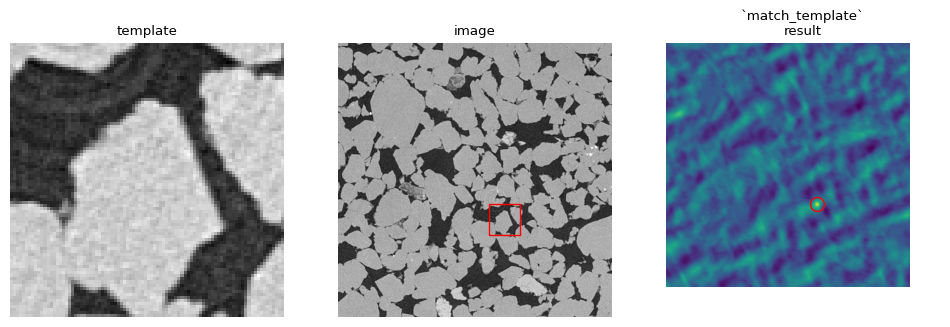

In [77]:
match_template_test(si.img_as_float(img_hr[:,:]),si.img_as_float(img_sub1[:,:]))     

## Improving contrast by histogram manipulation

Often, the image is so-called "low contrast" which refers to the values of the image having a small range. The example is shown for the fracture above. Note that the histogram of the sandstone slice is already spread over the entire range of possible values and it does not need manipulation like this. Sometimes, the fix is an easy "stretch" of the histogram (linear) to enhance contrast. Nonlinear manipulation attempts to create a uniform distribution of values. The following code, borrowed from skimage examples compares different manipulations of histogram.

References:
- https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
- Ch. 3. in "Digital Image Processing"

In [75]:
#This code is borrowed from the above scikit link 

#matplotlib.rcParams['font.size'] = 8

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


def try_all_histogram_changes(img):
    
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    # Equalization
    img_eq = exposure.equalize_hist(img)
    
    # Adaptive Equalization
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 4), dtype=object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1 + i, sharex=axes[0, 0], sharey=axes[0, 0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5 + i)
    
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')
    
    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))
    
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Contrast stretching')
    
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Histogram equalization')
    
    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
    ax_img.set_title('Adaptive equalization')
    
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))
    
    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

    return()

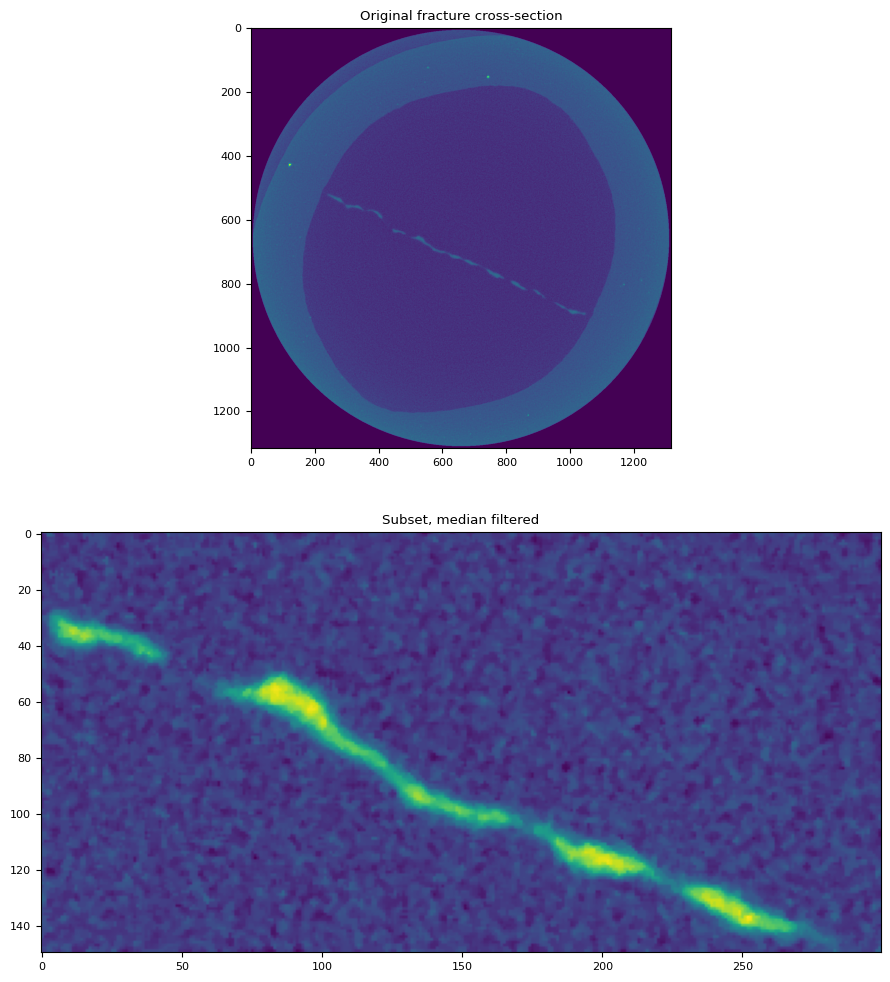

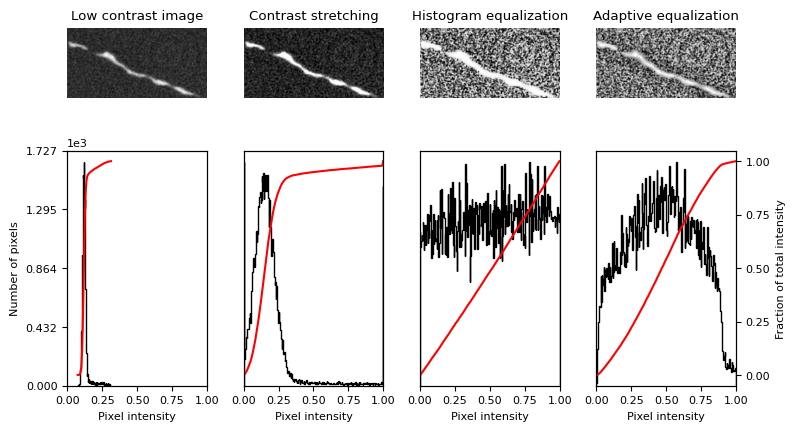

()

In [81]:
# Load an example image

import skimage.io as io

#Read a cropped slice through a fracture from Digital Rocks Portal
img_frac = io.imread('Project339_fracture_scan2_000130.tif')

f = plt.figure(figsize=(12, 12))
f.add_subplot(211)
#plt.imshow(img_frac,cmap='gray')
plt.imshow(img_frac)
plt.title('Original fracture cross-section')

locx = 600
lenx = 150
locy = 440
leny = 300

img = np.copy(img_frac[locx:(locx+lenx),locy:(locy+leny)])
img_med = sf.median(img,sm.square(3))

f.add_subplot(212)
#plt.imshow(img,cmap='gray')
plt.imshow(img_med)
plt.title('Subset, median filtered') # median filtering does not do much here

img_float = si.img_as_float(img_med)
try_all_histogram_changes(img_float) 

# Advanced: White tophat example FIND BETTER EXAMPLE

Grayscale erosion using a neighborhood or a structuring element surrounding a point means replacing the value at a point with the minimum of the points in its neighborhood.

Grayscale dilation is then defined as taking the maximum in a neighborhood of a point.

Opening = erosion followed by dilation.

Closing = dilation followed by erosion.


White top-hat transform is defined as the difference between the input image and its opening by some structuring element.
Black top-hat transform is defined as the difference between the input image and its opening by some structuring element.

The white top-hat transform returns an image, containing those "objects" or "elements" of an input image that:

    are "smaller" than the structuring element (i.e., places where the structuring element does not fit in), and
    are brighter than their surroundings.

The black top-hat returns an image, containing the "objects" or "elements" that:

    are "smaller" than the structuring element, and
    are darker than their surroundings.

The size, or width, of the elements that are extracted by the top-hat transforms can be controlled by the choice of the structuring element b. The bigger the latter, the larger the elements extracted.

Both top-hat transforms are images that contain only non-negative values at all pixels.

One of its most important uses in image segmentation is to adjust nonuniform lighting conditions on an image and provide a better threshold value for separating objects. 





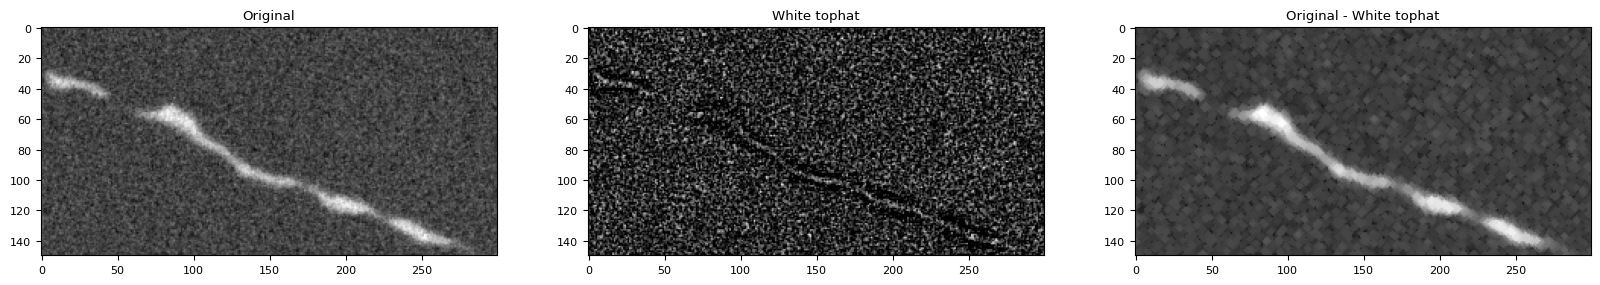

In [63]:
# This is not the best example for use of the top hat. Using it as a stand-in.

from skimage import morphology

def top_hat_filter_demo(image):
    selem =  morphology.disk(2)
    res = morphology.white_tophat(image, selem)

    fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
    ax[0].set_title('Original')
    ax[0].imshow(image, cmap='gray')
    ax[1].set_title('White tophat')
    ax[1].imshow(res, cmap='gray')
    ax[2].set_title('Original - White tophat')
    ax[2].imshow(image - res, cmap='gray')

    plt.show()
    image_filtered = image - res
    return (image - res)

img_filtered = top_hat_filter_demo(img_float)